In [1]:
import uproot as up
import awkward as ak
import vector
vector.register_awkward()
import numpy as np
from matplotlib import pyplot as plt
import xgboost as xgb

In [2]:
from applyCorrections import apply_corrections

In [3]:
global K
K = ( 40000000 * (2750 / 3564) )

# Load data

In [4]:
def get_branch(data, l1jet):
    
    # Get list of branches relating to the given jet
    interestingBranches = [branch for branch in data.keys() if l1jet in branch and not f"n{l1jet}" in branch]# and not f"{l1jet}_dau0" in branch] 
    
    # Get only branches corresponding to the desired l1jet
    l1jetData = data.arrays(interestingBranches)
    
    # Get a dictionary relating default branch names to new branch names (ie without leading ak8PuppiJets_...)
    renamedFields = {field : field.split('_', maxsplit=1)[-1] for field in interestingBranches}

    # Create a new awkward array with the desired l1jet branches and the new branch names
    arr = ak.Array({renamedFields[field]: l1jetData[field] for field in l1jetData.fields})
    
    array_dict = {key: arr[key] for key in arr.fields}
    quarks4mom = ak.zip(array_dict)
    quarks4mom = ak.with_name(quarks4mom, "Momentum4D")
    
    return quarks4mom

## Signal

In [5]:
sig_path = "/eos/user/l/lroberts/Jet_Mass/CMSSW_14_2_0_pre2/src/FastPUPPI/condor/jobs/lightHbb_M20to80_Pt50to200_1741980301/data/lightHbb_M20to80_Pt50to200.root"
jet = "sc8PuppiEmuJets_"

sig = up.open(sig_path)["Events"]
sig_jets = get_branch(sig, jet)
sig_jets = ak.with_field(sig_jets, np.sqrt(sig_jets.mass), where="mass")

## Background

In [6]:
bkg_path = "/eos/home-l/lroberts/Jet_Mass/CMSSW_14_2_0_pre2/src/FastPUPPI/condor/jobs/Phase2Spring24_SingleNeutrino_NoDau_PU200_1742483212/data/SingleNeutrino_NoDau_PU200.root"
jet = "sc8PuppiEmuJets_"

bkg = up.open(bkg_path)["Events"]
bkg_jets = get_branch(bkg, jet)
bkg_jets = ak.with_field(bkg_jets, np.sqrt(bkg_jets.mass), where="mass")

# Apply corrections

In [7]:
regressor = xgb.XGBRegressor()
regressor.load_model("model.json")

In [8]:
sig_corr = apply_corrections(sig_jets, regressor)

/cvmfs/sft.cern.ch/lcg/views/LCG_106a_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:246: RuntimeWarning: divide by zero encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))
/cvmfs/sft.cern.ch/lcg/views/LCG_106a_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:246: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


In [9]:
bkg_corr = apply_corrections(bkg_jets, regressor)

# Form event-level triggers

In [10]:
""" MASS TRIGGERS """
# Sum of jet mass trigger
total = lambda mass: ak.sum(mass, axis=-1)
# Leading jet mass trigger
leading = lambda mass: ak.firsts(mass)
# Leading two jet masses trigger
top2 = lambda mass: mass[:,:2]

# Process bkg to get rate

# At a fixed rate of X kHz, how efficient are we at signal?

## As a FREFF

In [11]:
def rate_from_thresh(bkg_jets, trigger, var, threshold):
    rate = K * ( 
        ak.sum( trigger(bkg_jets[var]) > threshold ) / len(bkg_jets)
    )
    print(f"Rate = {np.round(rate/1000,2)} kHz")
    return rate

In [12]:
def thresh_from_rate(bkg_jets, trigger, var, rate):

    N = np.floor( (rate / K) * len(bkg_jets) )
    
    threshold = 0
    while ak.sum( trigger(bkg_jets[var]) > threshold ) > N:
        threshold += 0.25
        
    return threshold

# What if we want to select events not already selected by pT?

In [13]:
from scipy.optimize import differential_evolution as de

In [14]:
def func(sels):
    ptSel, massSel = sels
    trigger = leading
    rate = K * ( ( ak.sum( (trigger(bkg_corr["pt"]) > ptSel) | (trigger(bkg_corr["mass_corr"]) > massSel ) ) ) / len(bkg_corr) )
    
    if rate > 60000:
        return 999999
    else:
        mask = (trigger(sig_corr["pt"]) > ptSel) | (trigger(sig_corr["mass_corr"]) > massSel)
        return -1 * ak.sum( mask )

In [15]:
res = de(func = func,
         bounds = [(0, 200), (0, 200)],
         x0 = (125.5, 0),
         polish=False,
         disp=True,
         popsize=30,
         strategy="rand2bin"
        )

differential_evolution step 1: f(x)= -12814.0
differential_evolution step 2: f(x)= -12814.0
differential_evolution step 3: f(x)= -12960.0
differential_evolution step 4: f(x)= -12960.0
differential_evolution step 5: f(x)= -12960.0
differential_evolution step 6: f(x)= -12960.0
differential_evolution step 7: f(x)= -12960.0
differential_evolution step 8: f(x)= -13093.0
differential_evolution step 9: f(x)= -13093.0
differential_evolution step 10: f(x)= -13093.0
differential_evolution step 11: f(x)= -13093.0
differential_evolution step 12: f(x)= -13160.0
differential_evolution step 13: f(x)= -13160.0
differential_evolution step 14: f(x)= -13160.0
differential_evolution step 15: f(x)= -13160.0
differential_evolution step 16: f(x)= -13160.0
differential_evolution step 17: f(x)= -13160.0
differential_evolution step 18: f(x)= -13160.0
differential_evolution step 19: f(x)= -13160.0
differential_evolution step 20: f(x)= -13160.0
differential_evolution step 21: f(x)= -13160.0
differential_evolution

In [16]:
res

             message: Optimization terminated successfully.
             success: True
                 fun: -13191.0
                   x: [ 1.371e+02  4.233e+01]
                 nit: 78
                nfev: 4740
          population: [[ 1.371e+02  4.233e+01]
                       [ 1.294e+02  5.019e+01]
                       ...
                       [ 1.325e+02  4.449e+01]
                       [ 1.329e+02  4.410e+01]]
 population_energies: [-1.319e+04 -1.295e+04 ... -1.318e+04 -1.318e+04]

In [17]:
def freff(sig_jet, trigger, genvar, *thresholds):
    plt.figure(figsize=(12,8))
    
    genObj = trigger(sig_jet[f"{genvar}"])
    ptObj = trigger(sig_jet[f"pt"])
    massObj = trigger(sig_jet[f"mass_corr"])

    bins = np.linspace(0, 300, 16)
    xs = (bins + (bins[1]/2))[:-1]
    for threshold in thresholds:
        ptThresh, massThresh = threshold
        ys, errs = [], []
        for b in range( len(bins) - 1 ):
            mask = (genObj >= bins[b]) & (genObj < bins[b+1])
            denominator = ak.sum(mask)
            
            ptObjInBin, massObjInBin = ptObj[mask], massObj[mask]
            numerator = ak.sum( (ptObjInBin > ptThresh) | (massObjInBin > massThresh) )    # of events in that bin, does the L1 quantity survive the threshold?
            
            eff = numerator / denominator
            ys.append( eff )
            err = np.sqrt((eff*(1-eff)) / denominator)
            errs.append(err)
        
        plt.errorbar(xs, ys, xerr=xs[0], fmt="-o", yerr=errs, label=f"pT threshold: {ptThresh} GeV\nMass threshold: {massThresh} GeV", capsize=6)
        
    plt.axhline(0.95, linestyle="--", color="black")
    plt.xticks(bins, fontsize=12); plt.yticks(np.linspace(0,1,11), fontsize=12)
    plt.xlim(bins[0]-xs[0], bins[-1]+xs[0]); plt.ylim(-0.05, 1.05)
    plt.xlabel(f"Leading gen jet pT", fontsize=16); plt.ylabel("Efficiency @ 60 kHz", fontsize=16)
    plt.title("Light H --> bb, Higgs has (pT, mass): ((20, 50), (40, 100), (60, 150) and (80, 200))", fontsize=16)
    plt.grid()
    plt.legend(fontsize=12)
    plt.show()

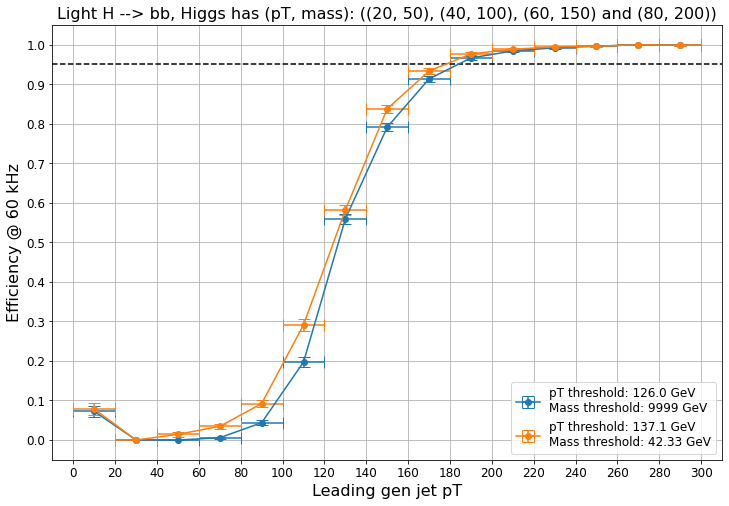

In [18]:
freff(sig_corr, leading, "genpt", (126.0, 9999), (137.1, 42.33))

In [ ]:
surviving_leaders = (leading(sig_corr)[leading(sig_corr).genpt>175])

In [ ]:
ak.sum( (surviving_leaders.pt > 138.9)|(surviving_leaders.mass>22.22) ) 

In [ ]:
ak.sum(leading(sig_corr["pt"]) > 126)